# CNN - Convolutional Neural Networks

Iremos usar diferentes arquiteturas de MLP para comparar os resultados com dados vindo do FASHION MNIST. Nos testes, usarei o FASHION MNIST normal (com as imagens com 28px de dimensão), uma versão com as imagens transladadas aleatoriamente numa dimensão de 84 $\times$ 84 pixels e por fim as imagens na dimensão original, mas centralizadas numa dimensão de 84 $\times$ 84. 

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

## Preparo dos Dados:

Nossa ideia vai ser produzir 3 datasets diferentes:
- Dataset A - Fashion MNIST normal;
- Dataset B - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixels aleatoriamente a cada chamada;
- Dataset C - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixel de forma fixa;

In [2]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, borda=28, transformar=True, transladar_fixo=True):
        self.data = pd.read_csv(csv_file)
        self.imagens = self.data.drop(columns=['label']).values / 255.0
        self.rotulos = self.data['label'].values
        self.borda = borda
        self.transformar = transformar  
        self.transladar_fixo = transladar_fixo

        if self.transformar & self.transladar_fixo:
            self.imagens = [self.transform_imagens(torch.tensor(imagem, dtype=torch.float).view(1, 28, 28)) for imagem in self.imagens]

    def __len__(self):
        return len(self.rotulos)

    def transform_imagens(self, X):
        novoX = torch.zeros(1, 28 + 2 * self.borda, 28 + 2 * self.borda)
        inicio_h = random.randint(0, 2 * self.borda)
        inicio_v = random.randint(0, 2 * self.borda)
        novoX[0, inicio_h:(inicio_h + 28), inicio_v:(inicio_v + 28)] = X.view(28, 28)
        return novoX

    def __getitem__(self, idx):
        if self.transladar_fixo:
            return self.imagens[idx], torch.tensor(self.rotulos[idx], dtype=torch.long)
        else:
            imagem = torch.tensor(self.imagens[idx], dtype=torch.float).view(1, 28, 28)
            rotulo = torch.tensor(self.rotulos[idx], dtype=torch.long)
            
            if self.transformar:
                imagem = self.transform_imagens(imagem)

            return imagem, rotulo
    
path_treino = 'datasets/fashion-mnist_train.csv'
path_teste = 'datasets/fashion-mnist_test.csv'

#### Dataset A - Fashion MNIST Normal

In [3]:
dataset_aux = FashionMNISTDataset(path_treino, borda=0, transformar=False, transladar_fixo=False)
treino_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [4]:
dataset_aux = FashionMNISTDataset(path_teste, borda=0, transformar=False, transladar_fixo=False)
teste_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Dataset B - Fashion MNIST Transladado Fixamente 

In [5]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=True)
treino_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [6]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=True)
teste_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Dataset C - Fashion MNIST Transladado Aleatoriamente

In [7]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=False)
treino_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [8]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=False)
teste_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

## CNN - Definições das Arquiteturas

Vamos usar 4 arquiteturas diferentes de CNN:

#### CNN 1 - Modelo 3C-3K-3M-2F

In [10]:
class CNN_Model_1(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 8) ** 2
        self.fc1 = nn.Linear(self.aux, 128)
        self.fc2 = nn.Linear(128, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

#### CNN 2 - Modelo 3C-3K-2M-4F

In [11]:
class CNN_Model_2(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 4) ** 2
        self.fc1 = nn.Linear(self.aux, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x

#### CNN 3 - Modelo 3C-53K-3M-2F

In [12]:
class CNN_Model_3(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 8) ** 2
        self.fc1 = nn.Linear(self.aux, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x

#### CNN 4 - Modelo 3C-53K-2M-4F

In [13]:
class CNN_Model_4(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(CNN_Model_4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Vou fazer 1 pooling após cada convolução;

        self.aux = 128 * (tamanho_entrada // 4) ** 2
        self.fc1 = nn.Linear(self.aux, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, tamanho_saida)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, self.aux)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x

## Treinamento:

### Funções de Plotagem:

In [14]:
def plot_side_by_side(lista_perdas, acuracias_treino, acuracias_teste):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

    # Plot para lista_perdas
    ax1.plot(lista_perdas, label='Transformada')
    ax1.set_title('Perdas')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()

    # Plot para acuracias_treino e acuracias_teste
    ax2.plot(acuracias_treino, label='Treino', color='orange')
    ax2.plot(acuracias_teste, label='Teste', color='blue')
    ax2.set_title('Acurácias: Treino vs Teste')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia')
    ax2.legend()

    plt.tight_layout()  
    plt.show()

### Acurácia & Teste:

In [15]:
def acuracia(saidas, rotulos):
    _, predicao = torch.max(saidas, 1)
    return (predicao == rotulos).sum().item() / len(predicao)

def teste(modelo, test_loader):
    modelo.eval()
    total_acertos = 0
    total_amostras = 0

    with torch.no_grad():
        for dados_teste, rotulos_teste in test_loader:
            dados_teste = dados_teste.to('cuda')
            rotulos_teste = rotulos_teste.to('cuda')

            saidas = modelo(dados_teste)
            total_acertos += (saidas.argmax(dim=1) == rotulos_teste).sum().item()
            total_amostras += rotulos_teste.size(0)
            del dados_teste, rotulos_teste, saidas
            torch.cuda.empty_cache()

    acc_total = total_acertos / total_amostras
    # print(f' >> Acurácia: {acc_total:.2f}')
    return acc_total

### Funções de Treino:

In [16]:
def treino(modelo, otimizador, perda, dados, dados_teste, num_epocas = 10):
    lista_perdas = []
    acuracias_treino = []
    acuracias_teste = []

    modelo.train()

    for epoca in range(num_epocas):
        print(f'Época: {epoca + 1}/{num_epocas}')
        total_acertos = 0
        total_amostras = 0
        perdas_por_batch = []

        for dados_batch, rotulos_batch in dados:
            dados_batch = dados_batch.to('cuda')
            rotulos_batch = rotulos_batch.to('cuda')

            otimizador.zero_grad()
            saidas = modelo(dados_batch)

            total_acertos += (saidas.argmax(dim=1) == rotulos_batch).sum().item()
            # print(rotulos_batch.size(0))
            total_amostras += rotulos_batch.size(0)


            erro = perda(saidas, rotulos_batch)
            erro.backward()
            otimizador.step()
            perdas_por_batch.append(erro.item())

            del dados_batch, rotulos_batch, saidas, erro
            torch.cuda.empty_cache()
        lista_perdas.append(sum(perdas_por_batch) / len(perdas_por_batch))
        acuracias_treino.append(total_acertos / total_amostras)
        acuracias_teste.append(teste(modelo, dados_teste))
        print(f'Época {epoca + 1}: Acurácia Treino: {acuracias_treino[-1]:.2f}')
        print(f'Época {epoca + 1}: Acurácia Teste: {acuracias_teste[-1]:.2f}')


    return lista_perdas, acuracias_teste, acuracias_treino

### Instâncias de Modelos e Treinos:

#### Dataset A:

##### Modelo 1 (3C-3K-3M-2F):

In [16]:
modelo_1_a = CNN_Model_1(28, 10).to('cuda')
perda = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(modelo_1_a.parameters(), lr=0.0001)

>>> Modelo 1 - Dataset A
Época: 1/40
Época 1: Acurácia Treino: 0.70
Época 1: Acurácia Teste: 0.79
Época: 2/40
Época 2: Acurácia Treino: 0.80
Época 2: Acurácia Teste: 0.82
Época: 3/40
Época 3: Acurácia Treino: 0.83
Época 3: Acurácia Teste: 0.84
Época: 4/40
Época 4: Acurácia Treino: 0.85
Época 4: Acurácia Teste: 0.86
Época: 5/40
Época 5: Acurácia Treino: 0.86
Época 5: Acurácia Teste: 0.87
Época: 6/40
Época 6: Acurácia Treino: 0.87
Época 6: Acurácia Teste: 0.87
Época: 7/40
Época 7: Acurácia Treino: 0.88
Época 7: Acurácia Teste: 0.88
Época: 8/40
Época 8: Acurácia Treino: 0.88
Época 8: Acurácia Teste: 0.88
Época: 9/40
Época 9: Acurácia Treino: 0.89
Época 9: Acurácia Teste: 0.89
Época: 10/40
Época 10: Acurácia Treino: 0.89
Época 10: Acurácia Teste: 0.89
Época: 11/40
Época 11: Acurácia Treino: 0.90
Época 11: Acurácia Teste: 0.89
Época: 12/40
Época 12: Acurácia Treino: 0.90
Época 12: Acurácia Teste: 0.90
Época: 13/40
Época 13: Acurácia Treino: 0.90
Época 13: Acurácia Teste: 0.90
Época: 14/40
É

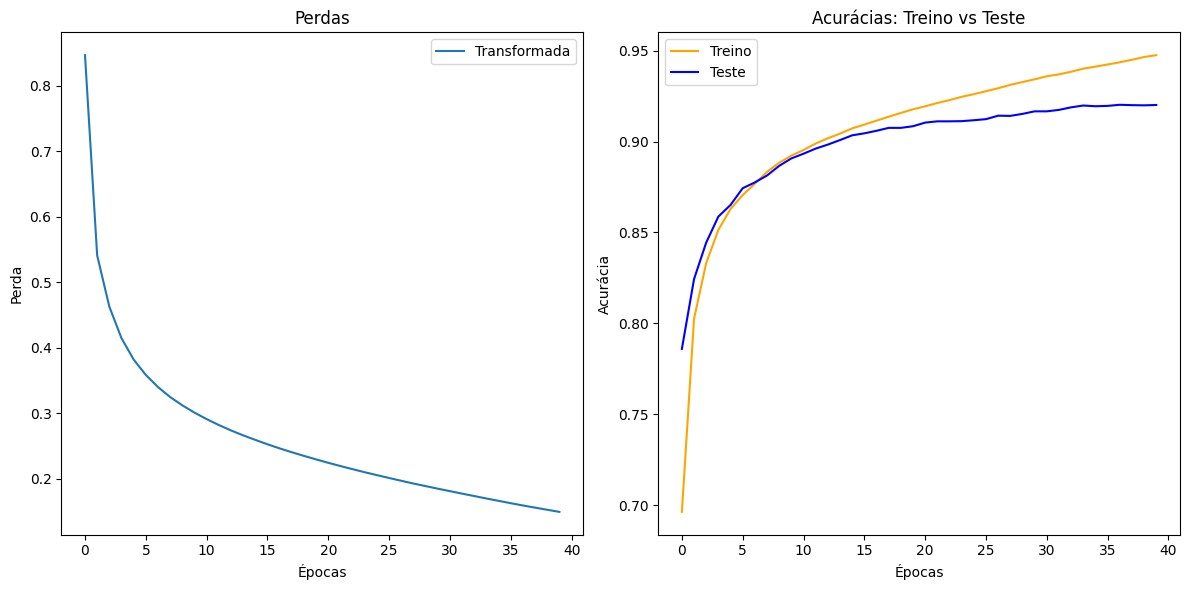

In [17]:
#### Dataset A
print('>>> Modelo 1 - Dataset A')
lista_perdas_1_A, acuracias_teste_1_A, acuracias_treino_1_A = treino(modelo_1_a, otimizador, perda, treino_loader_A, teste_loader_A, num_epocas=40)
plot_side_by_side(lista_perdas_1_A, acuracias_treino_1_A, acuracias_teste_1_A)

##### Modelo 2 (3C-3K-2M-4F):

In [18]:
modelo_2_a = CNN_Model_2(28, 10).to('cuda')
otimizador = torch.optim.Adam(modelo_2_a.parameters(), lr=0.0001)
perda = nn.CrossEntropyLoss()

>>> Modelo 2 - Dataset A
Época: 1/20
Época 1: Acurácia Treino: 0.74
Época 1: Acurácia Teste: 0.82
Época: 2/20
Época 2: Acurácia Treino: 0.84
Época 2: Acurácia Teste: 0.85
Época: 3/20
Época 3: Acurácia Treino: 0.87
Época 3: Acurácia Teste: 0.87
Época: 4/20
Época 4: Acurácia Treino: 0.88
Época 4: Acurácia Teste: 0.88
Época: 5/20
Época 5: Acurácia Treino: 0.89
Época 5: Acurácia Teste: 0.88
Época: 6/20
Época 6: Acurácia Treino: 0.90
Época 6: Acurácia Teste: 0.89
Época: 7/20
Época 7: Acurácia Treino: 0.90
Época 7: Acurácia Teste: 0.90
Época: 8/20
Época 8: Acurácia Treino: 0.91
Época 8: Acurácia Teste: 0.90
Época: 9/20
Época 9: Acurácia Treino: 0.91
Época 9: Acurácia Teste: 0.91
Época: 10/20
Época 10: Acurácia Treino: 0.92
Época 10: Acurácia Teste: 0.91
Época: 11/20
Época 11: Acurácia Treino: 0.92
Época 11: Acurácia Teste: 0.91
Época: 12/20
Época 12: Acurácia Treino: 0.93
Época 12: Acurácia Teste: 0.91
Época: 13/20
Época 13: Acurácia Treino: 0.93
Época 13: Acurácia Teste: 0.92
Época: 14/20
É

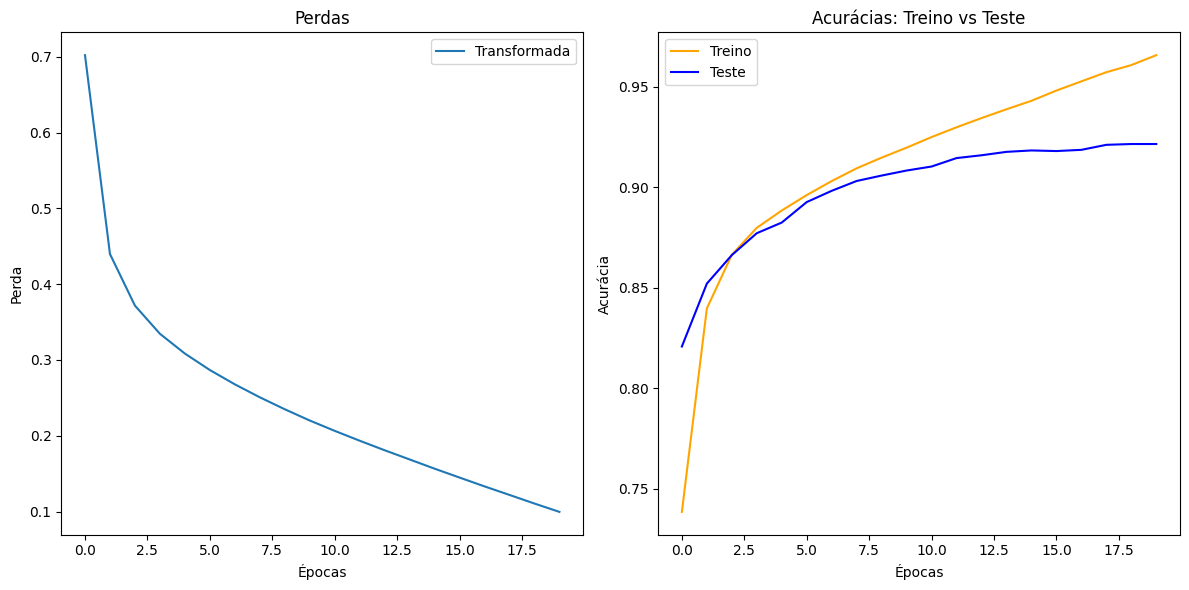

In [19]:
print('>>> Modelo 2 - Dataset A')
lista_perdas_2_A, acuracias_teste_2_A, acuracias_treino_2_A = treino(modelo_2_a, otimizador, perda, treino_loader_A, teste_loader_A, num_epocas=20)
plot_side_by_side(lista_perdas_2_A, acuracias_treino_2_A, acuracias_teste_2_A)

##### Modelo 3 (3C-53K-3M-2F)

In [20]:
modelo_3_a = CNN_Model_3(28, 10).to('cuda')
otimizador = torch.optim.Adam(modelo_3_a.parameters(), lr=0.0001)
perda = nn.CrossEntropyLoss()

>>> Modelo 3 - Dataset A
Época: 1/30
Época 1: Acurácia Treino: 0.70
Época 1: Acurácia Teste: 0.79
Época: 2/30
Época 2: Acurácia Treino: 0.81
Época 2: Acurácia Teste: 0.83
Época: 3/30
Época 3: Acurácia Treino: 0.84
Época 3: Acurácia Teste: 0.85
Época: 4/30
Época 4: Acurácia Treino: 0.86
Época 4: Acurácia Teste: 0.86
Época: 5/30
Época 5: Acurácia Treino: 0.87
Época 5: Acurácia Teste: 0.87
Época: 6/30
Época 6: Acurácia Treino: 0.87
Época 6: Acurácia Teste: 0.88
Época: 7/30
Época 7: Acurácia Treino: 0.88
Época 7: Acurácia Teste: 0.88
Época: 8/30
Época 8: Acurácia Treino: 0.89
Época 8: Acurácia Teste: 0.89
Época: 9/30
Época 9: Acurácia Treino: 0.89
Época 9: Acurácia Teste: 0.89
Época: 10/30
Época 10: Acurácia Treino: 0.89
Época 10: Acurácia Teste: 0.89
Época: 11/30
Época 11: Acurácia Treino: 0.90
Época 11: Acurácia Teste: 0.90
Época: 12/30
Época 12: Acurácia Treino: 0.90
Época 12: Acurácia Teste: 0.90
Época: 13/30
Época 13: Acurácia Treino: 0.90
Época 13: Acurácia Teste: 0.90
Época: 14/30
É

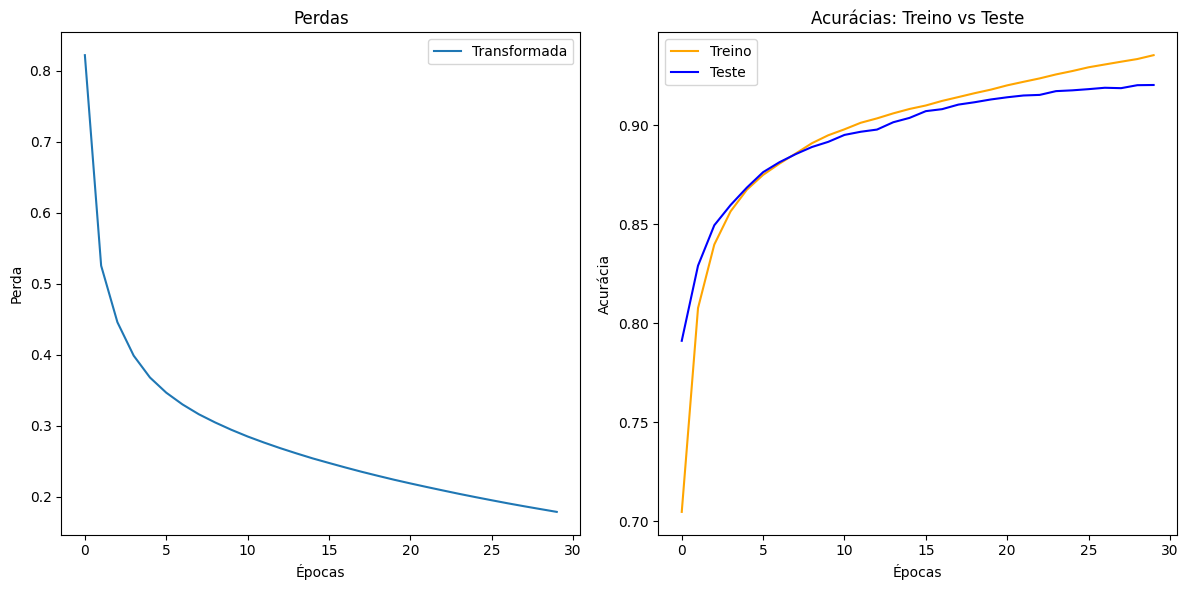

In [21]:
print('>>> Modelo 3 - Dataset A')
lista_perdas_3_A, acuracias_teste_3_A, acuracias_treino_3_A = treino(modelo_3_a, otimizador, perda, treino_loader_A, teste_loader_A, num_epocas=30)
plot_side_by_side(lista_perdas_3_A, acuracias_treino_3_A, acuracias_teste_3_A)

##### Modelo 4 (3C-53K-2M-4F):

>>> Modelo 4 - Dataset A
Época: 1/30
Época 1: Acurácia Treino: 0.74
Época 1: Acurácia Teste: 0.81
Época: 2/30
Época 2: Acurácia Treino: 0.84
Época 2: Acurácia Teste: 0.84
Época: 3/30
Época 3: Acurácia Treino: 0.86
Época 3: Acurácia Teste: 0.86
Época: 4/30
Época 4: Acurácia Treino: 0.88
Época 4: Acurácia Teste: 0.87
Época: 5/30
Época 5: Acurácia Treino: 0.89
Época 5: Acurácia Teste: 0.88
Época: 6/30
Época 6: Acurácia Treino: 0.89
Época 6: Acurácia Teste: 0.89
Época: 7/30
Época 7: Acurácia Treino: 0.90
Época 7: Acurácia Teste: 0.90
Época: 8/30
Época 8: Acurácia Treino: 0.91
Época 8: Acurácia Teste: 0.90
Época: 9/30
Época 9: Acurácia Treino: 0.91
Época 9: Acurácia Teste: 0.91
Época: 10/30
Época 10: Acurácia Treino: 0.92
Época 10: Acurácia Teste: 0.91
Época: 11/30
Época 11: Acurácia Treino: 0.92
Época 11: Acurácia Teste: 0.91
Época: 12/30
Época 12: Acurácia Treino: 0.93
Época 12: Acurácia Teste: 0.91
Época: 13/30
Época 13: Acurácia Treino: 0.93
Época 13: Acurácia Teste: 0.92
Época: 14/30
É

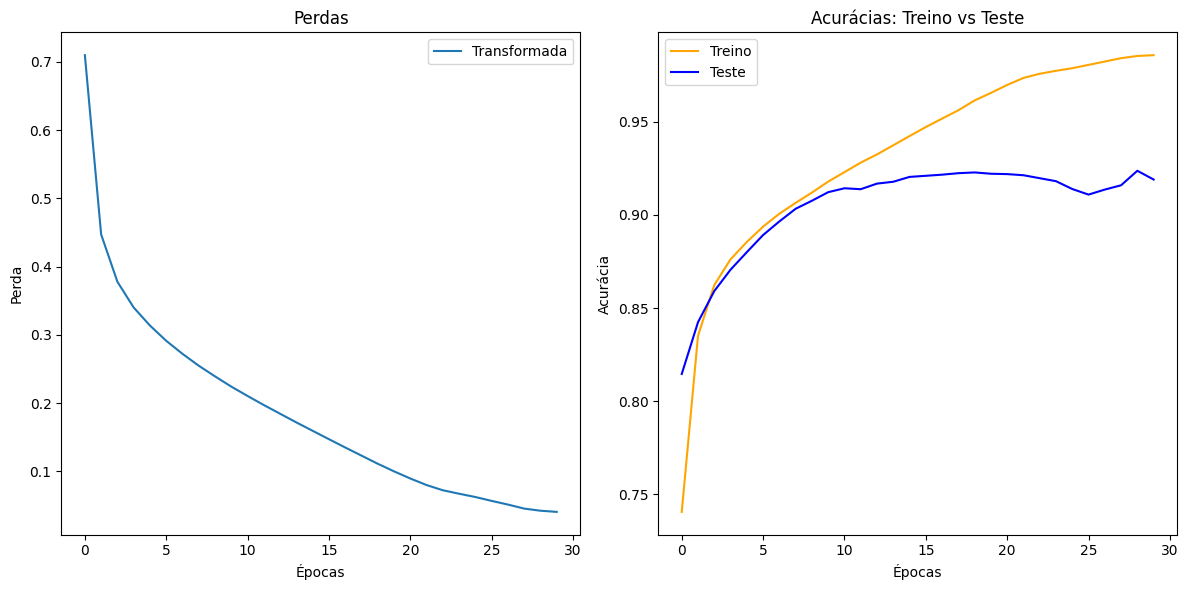

In [22]:
# Modelo 4 - Dataset A
modelo_4_a = CNN_Model_4(28, 10).to('cuda')
otimizador_4_a = torch.optim.Adam(modelo_4_a.parameters(), lr=0.0001)
perda_4_a = nn.CrossEntropyLoss()

print('>>> Modelo 4 - Dataset A')
lista_perdas_4_A, acuracias_teste_4_A, acuracias_treino_4_A = treino(modelo_4_a, otimizador_4_a, perda_4_a, treino_loader_A, teste_loader_A, num_epocas=30)
plot_side_by_side(lista_perdas_4_A, acuracias_treino_4_A, acuracias_teste_4_A)


#### Dataset B:

##### Modelo 1 (3C-3K-3M-2F):

>>> Modelo 1 - Dataset B
Época: 1/40
Época 1: Acurácia Treino: 0.51
Época 1: Acurácia Teste: 0.66
Época: 2/40
Época 2: Acurácia Treino: 0.69
Época 2: Acurácia Teste: 0.71
Época: 3/40
Época 3: Acurácia Treino: 0.72
Época 3: Acurácia Teste: 0.73
Época: 4/40
Época 4: Acurácia Treino: 0.74
Época 4: Acurácia Teste: 0.75
Época: 5/40
Época 5: Acurácia Treino: 0.75
Época 5: Acurácia Teste: 0.76
Época: 6/40
Época 6: Acurácia Treino: 0.77
Época 6: Acurácia Teste: 0.77
Época: 7/40
Época 7: Acurácia Treino: 0.78
Época 7: Acurácia Teste: 0.77
Época: 8/40
Época 8: Acurácia Treino: 0.78
Época 8: Acurácia Teste: 0.78
Época: 9/40
Época 9: Acurácia Treino: 0.79
Época 9: Acurácia Teste: 0.78
Época: 10/40
Época 10: Acurácia Treino: 0.80
Época 10: Acurácia Teste: 0.79
Época: 11/40
Época 11: Acurácia Treino: 0.81
Época 11: Acurácia Teste: 0.79
Época: 12/40
Época 12: Acurácia Treino: 0.81
Época 12: Acurácia Teste: 0.80
Época: 13/40
Época 13: Acurácia Treino: 0.82
Época 13: Acurácia Teste: 0.80
Época: 14/40
É

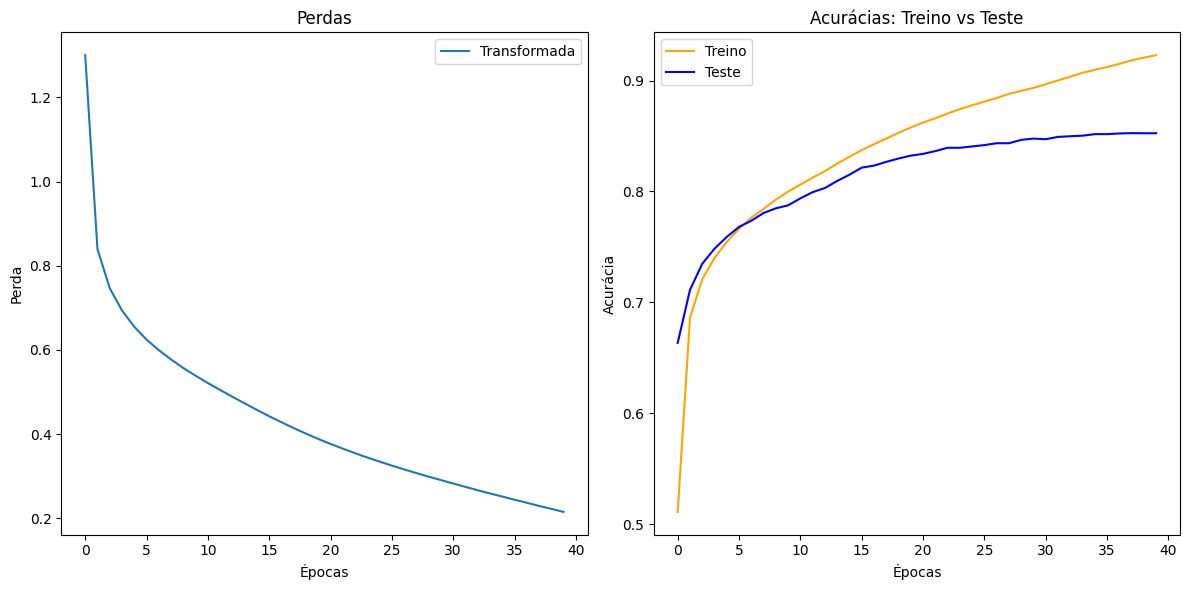

In [24]:
# Modelo 1 - Dataset B
modelo_1_b = CNN_Model_1(56, 10).to('cuda')
otimizador_1_b = torch.optim.Adam(modelo_1_b.parameters(), lr=0.0001)
perda_1_b = nn.CrossEntropyLoss()

print('>>> Modelo 1 - Dataset B')
lista_perdas_1_B, acuracias_teste_1_B, acuracias_treino_1_B = treino(modelo_1_b, otimizador_1_b, perda_1_b, treino_loader_B, teste_loader_B, num_epocas=40)
plot_side_by_side(lista_perdas_1_B, acuracias_treino_1_B, acuracias_teste_1_B)

##### Modelo 2 (3C-3K-2M-4F):

>>> Modelo 2 - Dataset B
Época: 1/30
Época 1: Acurácia Treino: 0.52
Época 1: Acurácia Teste: 0.65
Época: 2/30
Época 2: Acurácia Treino: 0.70
Época 2: Acurácia Teste: 0.72
Época: 3/30
Época 3: Acurácia Treino: 0.73
Época 3: Acurácia Teste: 0.74
Época: 4/30
Época 4: Acurácia Treino: 0.75
Época 4: Acurácia Teste: 0.75
Época: 5/30
Época 5: Acurácia Treino: 0.76
Época 5: Acurácia Teste: 0.76
Época: 6/30
Época 6: Acurácia Treino: 0.77
Época 6: Acurácia Teste: 0.77
Época: 7/30
Época 7: Acurácia Treino: 0.78
Época 7: Acurácia Teste: 0.78
Época: 8/30
Época 8: Acurácia Treino: 0.79
Época 8: Acurácia Teste: 0.78
Época: 9/30
Época 9: Acurácia Treino: 0.81
Época 9: Acurácia Teste: 0.79
Época: 10/30
Época 10: Acurácia Treino: 0.81
Época 10: Acurácia Teste: 0.80
Época: 11/30
Época 11: Acurácia Treino: 0.82
Época 11: Acurácia Teste: 0.80
Época: 12/30
Época 12: Acurácia Treino: 0.83
Época 12: Acurácia Teste: 0.81
Época: 13/30
Época 13: Acurácia Treino: 0.84
Época 13: Acurácia Teste: 0.81
Época: 14/30
É

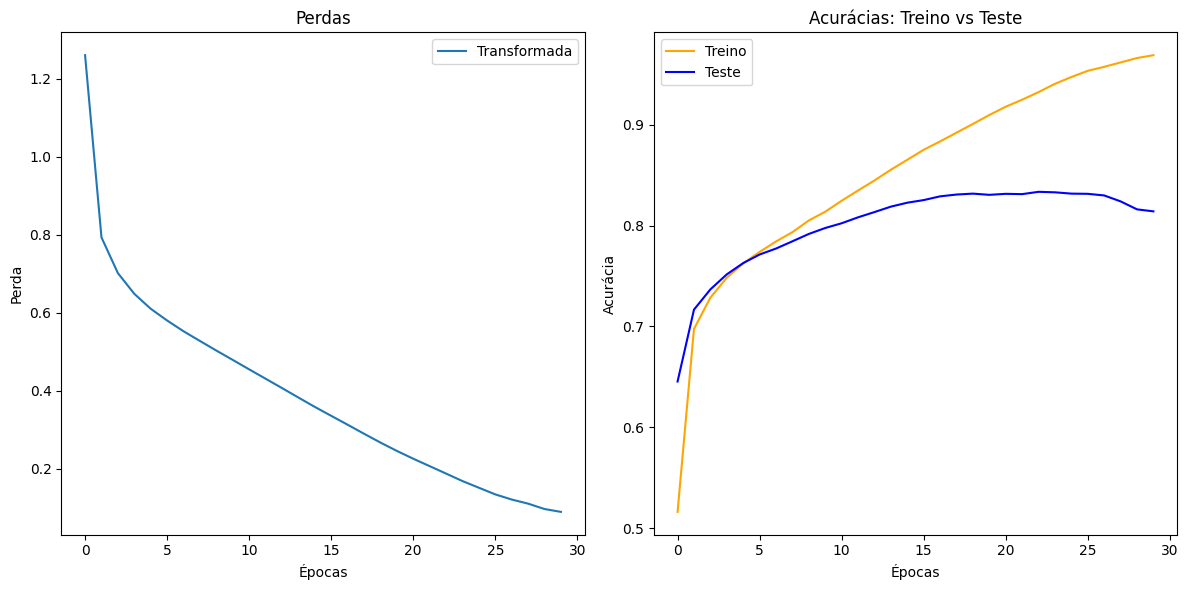

In [26]:
# Modelo 2 - Dataset B
modelo_2_b = CNN_Model_2(56, 10).to('cuda')
otimizador_2_b = torch.optim.Adam(modelo_2_b.parameters(), lr=0.0001)
perda_2_b = nn.CrossEntropyLoss()

print('>>> Modelo 2 - Dataset B')
lista_perdas_2_B, acuracias_teste_2_B, acuracias_treino_2_B = treino(modelo_2_b, otimizador_2_b, perda_2_b, treino_loader_B, teste_loader_B, num_epocas=30)
plot_side_by_side(lista_perdas_2_B, acuracias_treino_2_B, acuracias_teste_2_B)

##### Modelo 3 (3C-53K-3M-2F)

>>> Modelo 3 - Dataset B
Época: 1/30
Época 1: Acurácia Treino: 0.54
Época 1: Acurácia Teste: 0.66
Época: 2/30
Época 2: Acurácia Treino: 0.70
Época 2: Acurácia Teste: 0.71
Época: 3/30
Época 3: Acurácia Treino: 0.73
Época 3: Acurácia Teste: 0.73
Época: 4/30
Época 4: Acurácia Treino: 0.74
Época 4: Acurácia Teste: 0.74
Época: 5/30
Época 5: Acurácia Treino: 0.76
Época 5: Acurácia Teste: 0.76
Época: 6/30
Época 6: Acurácia Treino: 0.77
Época 6: Acurácia Teste: 0.77
Época: 7/30
Época 7: Acurácia Treino: 0.78
Época 7: Acurácia Teste: 0.78
Época: 8/30
Época 8: Acurácia Treino: 0.79
Época 8: Acurácia Teste: 0.79
Época: 9/30
Época 9: Acurácia Treino: 0.80
Época 9: Acurácia Teste: 0.79
Época: 10/30
Época 10: Acurácia Treino: 0.81
Época 10: Acurácia Teste: 0.80
Época: 11/30
Época 11: Acurácia Treino: 0.82
Época 11: Acurácia Teste: 0.81
Época: 12/30
Época 12: Acurácia Treino: 0.83
Época 12: Acurácia Teste: 0.81
Época: 13/30
Época 13: Acurácia Treino: 0.83
Época 13: Acurácia Teste: 0.81
Época: 14/30
É

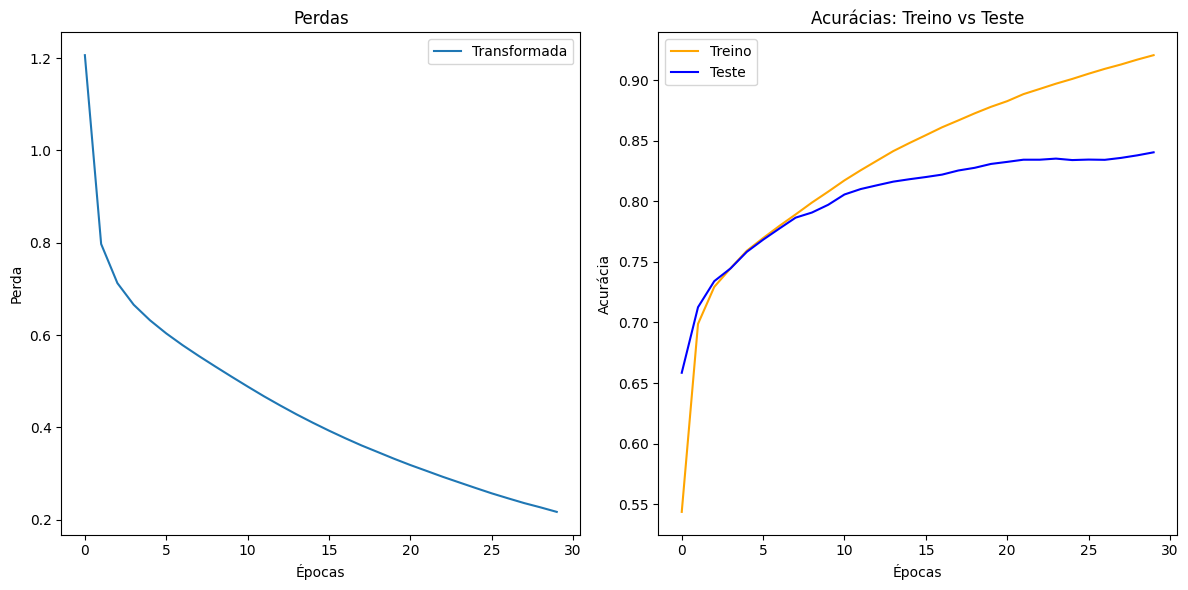

In [17]:
# Modelo 3 - Dataset B
modelo_3_b = CNN_Model_3(56, 10).to('cuda')
otimizador_3_b = torch.optim.Adam(modelo_3_b.parameters(), lr=0.0001)
perda_3_b = nn.CrossEntropyLoss()

print('>>> Modelo 3 - Dataset B')
lista_perdas_3_B, acuracias_teste_3_B, acuracias_treino_3_B = treino(modelo_3_b, otimizador_3_b, perda_3_b, treino_loader_B, teste_loader_B, num_epocas=30)
plot_side_by_side(lista_perdas_3_B, acuracias_treino_3_B, acuracias_teste_3_B)

##### Modelo 4 (3C-53K-2M-4F):

>>> Modelo 4 - Dataset B
Época: 1/30
Época 1: Acurácia Treino: 0.53
Época 1: Acurácia Teste: 0.65
Época: 2/30
Época 2: Acurácia Treino: 0.69
Época 2: Acurácia Teste: 0.71
Época: 3/30
Época 3: Acurácia Treino: 0.72
Época 3: Acurácia Teste: 0.73
Época: 4/30
Época 4: Acurácia Treino: 0.74
Época 4: Acurácia Teste: 0.75
Época: 5/30
Época 5: Acurácia Treino: 0.76
Época 5: Acurácia Teste: 0.76
Época: 6/30
Época 6: Acurácia Treino: 0.77
Época 6: Acurácia Teste: 0.76
Época: 7/30
Época 7: Acurácia Treino: 0.78
Época 7: Acurácia Teste: 0.77
Época: 8/30
Época 8: Acurácia Treino: 0.79
Época 8: Acurácia Teste: 0.78
Época: 9/30
Época 9: Acurácia Treino: 0.80
Época 9: Acurácia Teste: 0.79
Época: 10/30
Época 10: Acurácia Treino: 0.81
Época 10: Acurácia Teste: 0.79
Época: 11/30
Época 11: Acurácia Treino: 0.82
Época 11: Acurácia Teste: 0.80
Época: 12/30
Época 12: Acurácia Treino: 0.83
Época 12: Acurácia Teste: 0.80
Época: 13/30
Época 13: Acurácia Treino: 0.84
Época 13: Acurácia Teste: 0.81
Época: 14/30
É

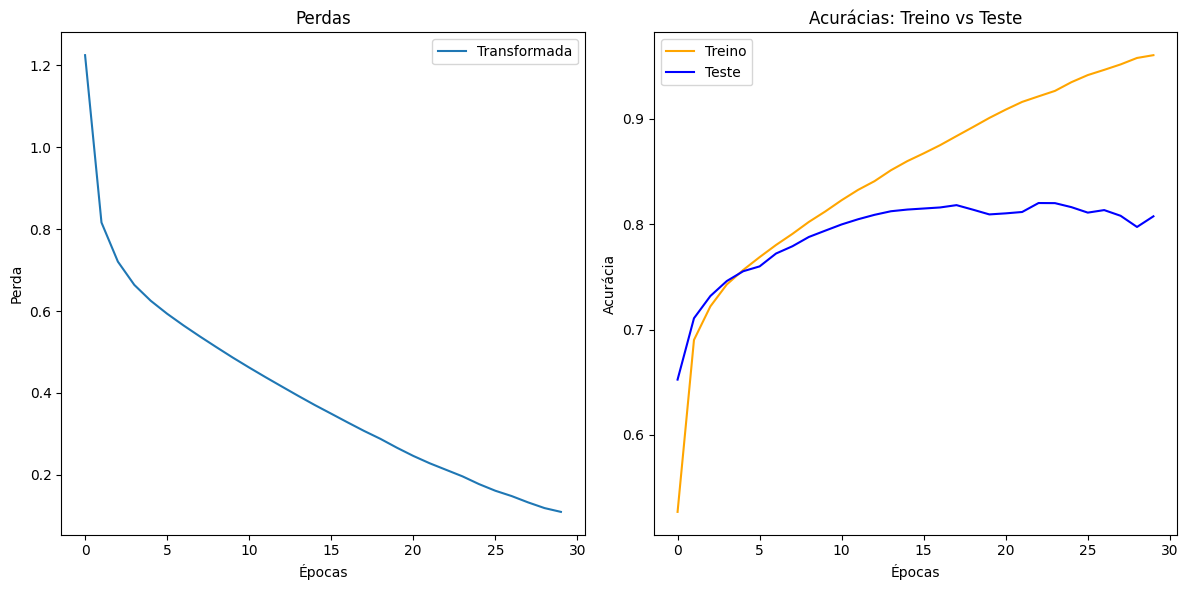

In [18]:
# Modelo 4 - Dataset B
modelo_4_b = CNN_Model_4(56, 10).to('cuda')
otimizador_4_b = torch.optim.Adam(modelo_4_b.parameters(), lr=0.0001)
perda_4_b = nn.CrossEntropyLoss()

print('>>> Modelo 4 - Dataset B')
lista_perdas_4_B, acuracias_teste_4_B, acuracias_treino_4_B = treino(modelo_4_b, otimizador_4_b, perda_4_b, treino_loader_B, teste_loader_B, num_epocas=30)
plot_side_by_side(lista_perdas_4_B, acuracias_treino_4_B, acuracias_teste_4_B)

#### Dataset C:

##### Modelo 1 (3C-3K-3M-2F):

>>> Modelo 1 - Dataset C
Época: 1/30
Época 1: Acurácia Treino: 0.63
Época 1: Acurácia Teste: 0.74
Época: 2/30
Época 2: Acurácia Treino: 0.77
Época 2: Acurácia Teste: 0.79
Época: 3/30
Época 3: Acurácia Treino: 0.80
Época 3: Acurácia Teste: 0.83
Época: 4/30
Época 4: Acurácia Treino: 0.83
Época 4: Acurácia Teste: 0.85
Época: 5/30
Época 5: Acurácia Treino: 0.85
Época 5: Acurácia Teste: 0.86
Época: 6/30
Época 6: Acurácia Treino: 0.87
Época 6: Acurácia Teste: 0.88
Época: 7/30
Época 7: Acurácia Treino: 0.88
Época 7: Acurácia Teste: 0.88
Época: 8/30
Época 8: Acurácia Treino: 0.88
Época 8: Acurácia Teste: 0.89
Época: 9/30
Época 9: Acurácia Treino: 0.89
Época 9: Acurácia Teste: 0.89
Época: 10/30
Época 10: Acurácia Treino: 0.89
Época 10: Acurácia Teste: 0.90
Época: 11/30
Época 11: Acurácia Treino: 0.90
Época 11: Acurácia Teste: 0.90
Época: 12/30
Época 12: Acurácia Treino: 0.90
Época 12: Acurácia Teste: 0.91
Época: 13/30
Época 13: Acurácia Treino: 0.90
Época 13: Acurácia Teste: 0.91
Época: 14/30
É

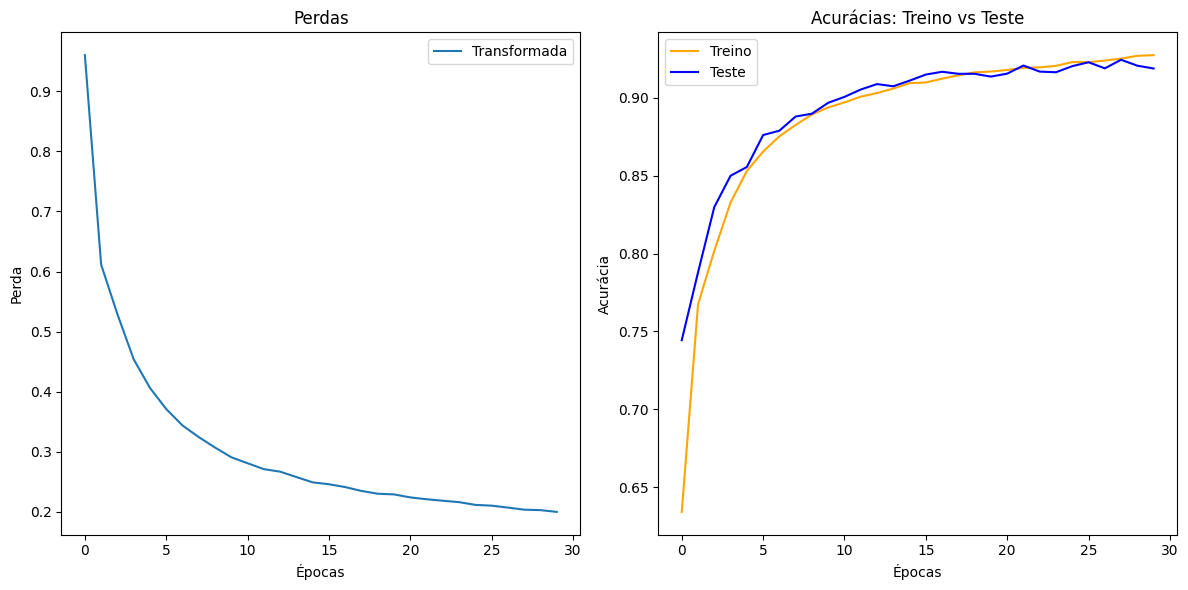

In [23]:
# Modelo 1 - Dataset C
modelo_1_c = CNN_Model_1(56, 10).to('cuda')
otimizador_1_c = torch.optim.Adam(modelo_1_c.parameters(), lr=0.001)
perda_1_c = nn.CrossEntropyLoss()

print('>>> Modelo 1 - Dataset C')
lista_perdas_1_C, acuracias_teste_1_C, acuracias_treino_1_C = treino(modelo_1_c, otimizador_1_c, perda_1_c, treino_loader_C, teste_loader_C, num_epocas=30)
plot_side_by_side(lista_perdas_1_C, acuracias_treino_1_C, acuracias_teste_1_C)

##### Modelo 2 (3C-3K-2M-4F):

>>> Modelo 2 - Dataset C
Época: 1/30
Época 1: Acurácia Treino: 0.65
Época 1: Acurácia Teste: 0.75
Época: 2/30
Época 2: Acurácia Treino: 0.79
Época 2: Acurácia Teste: 0.82
Época: 3/30
Época 3: Acurácia Treino: 0.83
Época 3: Acurácia Teste: 0.86
Época: 4/30
Época 4: Acurácia Treino: 0.86
Época 4: Acurácia Teste: 0.86
Época: 5/30
Época 5: Acurácia Treino: 0.87
Época 5: Acurácia Teste: 0.89
Época: 6/30
Época 6: Acurácia Treino: 0.88
Época 6: Acurácia Teste: 0.89
Época: 7/30
Época 7: Acurácia Treino: 0.89
Época 7: Acurácia Teste: 0.90
Época: 8/30
Época 8: Acurácia Treino: 0.90
Época 8: Acurácia Teste: 0.91
Época: 9/30
Época 9: Acurácia Treino: 0.90
Época 9: Acurácia Teste: 0.91
Época: 10/30
Época 10: Acurácia Treino: 0.90
Época 10: Acurácia Teste: 0.90
Época: 11/30
Época 11: Acurácia Treino: 0.91
Época 11: Acurácia Teste: 0.91
Época: 12/30
Época 12: Acurácia Treino: 0.91
Época 12: Acurácia Teste: 0.91
Época: 13/30
Época 13: Acurácia Treino: 0.91
Época 13: Acurácia Teste: 0.91
Época: 14/30
É

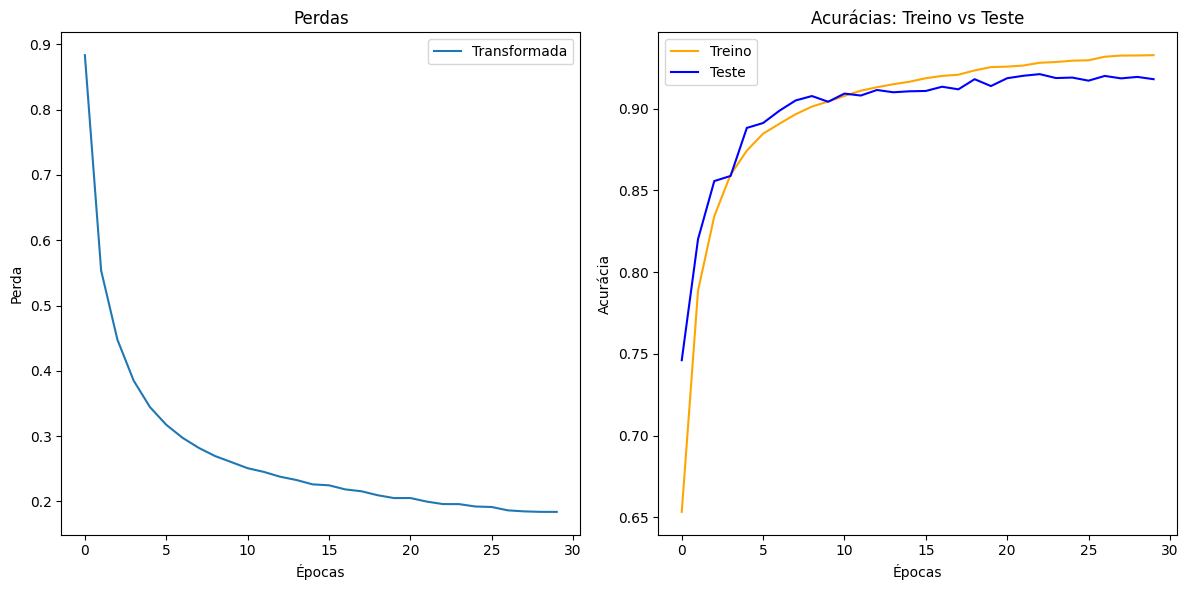

In [24]:
# Modelo 2 - Dataset C
modelo_2_c = CNN_Model_2(56, 10).to('cuda')
otimizador_2_c = torch.optim.Adam(modelo_2_c.parameters(), lr=0.001)
perda_2_c = nn.CrossEntropyLoss()

print('>>> Modelo 2 - Dataset C')
lista_perdas_2_C, acuracias_teste_2_C, acuracias_treino_2_C = treino(modelo_2_c, otimizador_2_c, perda_2_c, treino_loader_C, teste_loader_C, num_epocas=30)
plot_side_by_side(lista_perdas_2_C, acuracias_treino_2_C, acuracias_teste_2_C)

##### Modelo 3 (3C-53K-3M-2F)

>>> Modelo 3 - Dataset C
Época: 1/30
Época 1: Acurácia Treino: 0.67
Época 1: Acurácia Teste: 0.76
Época: 2/30
Época 2: Acurácia Treino: 0.79
Época 2: Acurácia Teste: 0.83
Época: 3/30
Época 3: Acurácia Treino: 0.83
Época 3: Acurácia Teste: 0.85
Época: 4/30
Época 4: Acurácia Treino: 0.85
Época 4: Acurácia Teste: 0.87
Época: 5/30
Época 5: Acurácia Treino: 0.87
Época 5: Acurácia Teste: 0.89
Época: 6/30
Época 6: Acurácia Treino: 0.88
Época 6: Acurácia Teste: 0.89
Época: 7/30
Época 7: Acurácia Treino: 0.89
Época 7: Acurácia Teste: 0.90
Época: 8/30
Época 8: Acurácia Treino: 0.89
Época 8: Acurácia Teste: 0.90
Época: 9/30
Época 9: Acurácia Treino: 0.90
Época 9: Acurácia Teste: 0.90
Época: 10/30
Época 10: Acurácia Treino: 0.90
Época 10: Acurácia Teste: 0.91
Época: 11/30
Época 11: Acurácia Treino: 0.90
Época 11: Acurácia Teste: 0.91
Época: 12/30
Época 12: Acurácia Treino: 0.91
Época 12: Acurácia Teste: 0.91
Época: 13/30
Época 13: Acurácia Treino: 0.91
Época 13: Acurácia Teste: 0.91
Época: 14/30
É

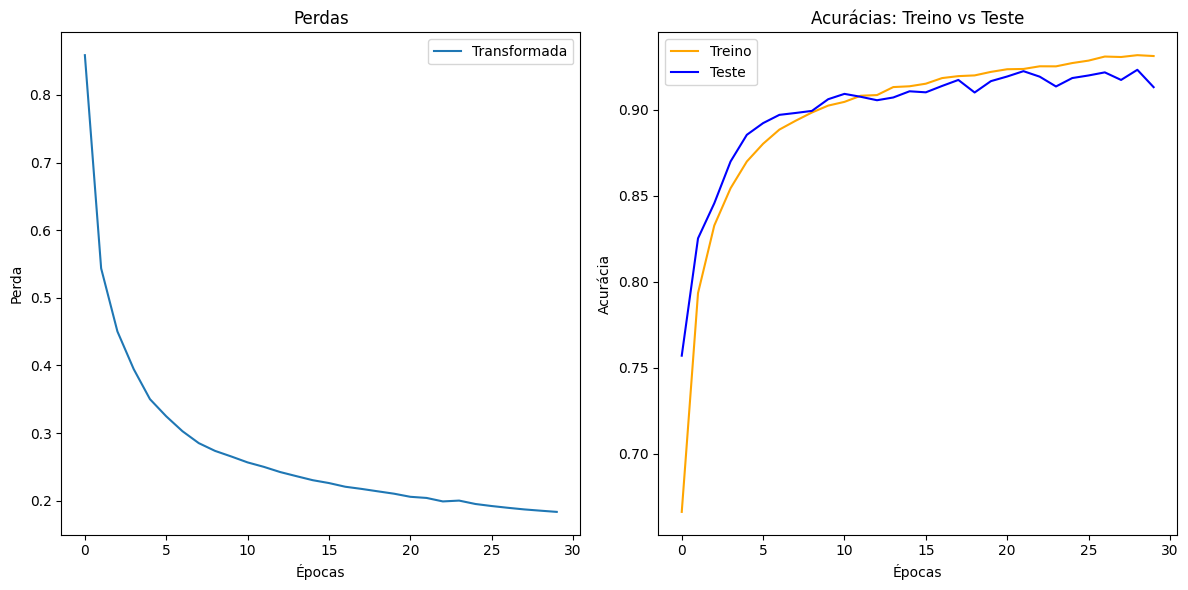

In [25]:
# Modelo 3 - Dataset C
modelo_3_c = CNN_Model_3(56, 10).to('cuda')
otimizador_3_c = torch.optim.Adam(modelo_3_c.parameters(), lr=0.001)
perda_3_c = nn.CrossEntropyLoss()

print('>>> Modelo 3 - Dataset C')
lista_perdas_3_C, acuracias_teste_3_C, acuracias_treino_3_C = treino(modelo_3_c, otimizador_3_c, perda_3_c, treino_loader_C, teste_loader_C, num_epocas=30)
plot_side_by_side(lista_perdas_3_C, acuracias_treino_3_C, acuracias_teste_3_C)

##### Modelo 4 (3C-53K-2M-4F):

>>> Modelo 4 - Dataset C
Época: 1/30
Época 1: Acurácia Treino: 0.63
Época 1: Acurácia Teste: 0.75
Época: 2/30
Época 2: Acurácia Treino: 0.78
Época 2: Acurácia Teste: 0.82
Época: 3/30
Época 3: Acurácia Treino: 0.83
Época 3: Acurácia Teste: 0.84
Época: 4/30
Época 4: Acurácia Treino: 0.85
Época 4: Acurácia Teste: 0.86
Época: 5/30
Época 5: Acurácia Treino: 0.86
Época 5: Acurácia Teste: 0.87
Época: 6/30
Época 6: Acurácia Treino: 0.87
Época 6: Acurácia Teste: 0.88
Época: 7/30
Época 7: Acurácia Treino: 0.88
Época 7: Acurácia Teste: 0.88
Época: 8/30
Época 8: Acurácia Treino: 0.89
Época 8: Acurácia Teste: 0.89
Época: 9/30
Época 9: Acurácia Treino: 0.89
Época 9: Acurácia Teste: 0.89
Época: 10/30
Época 10: Acurácia Treino: 0.90
Época 10: Acurácia Teste: 0.90
Época: 11/30
Época 11: Acurácia Treino: 0.90
Época 11: Acurácia Teste: 0.90
Época: 12/30
Época 12: Acurácia Treino: 0.91
Época 12: Acurácia Teste: 0.91
Época: 13/30
Época 13: Acurácia Treino: 0.91
Época 13: Acurácia Teste: 0.90
Época: 14/30
É

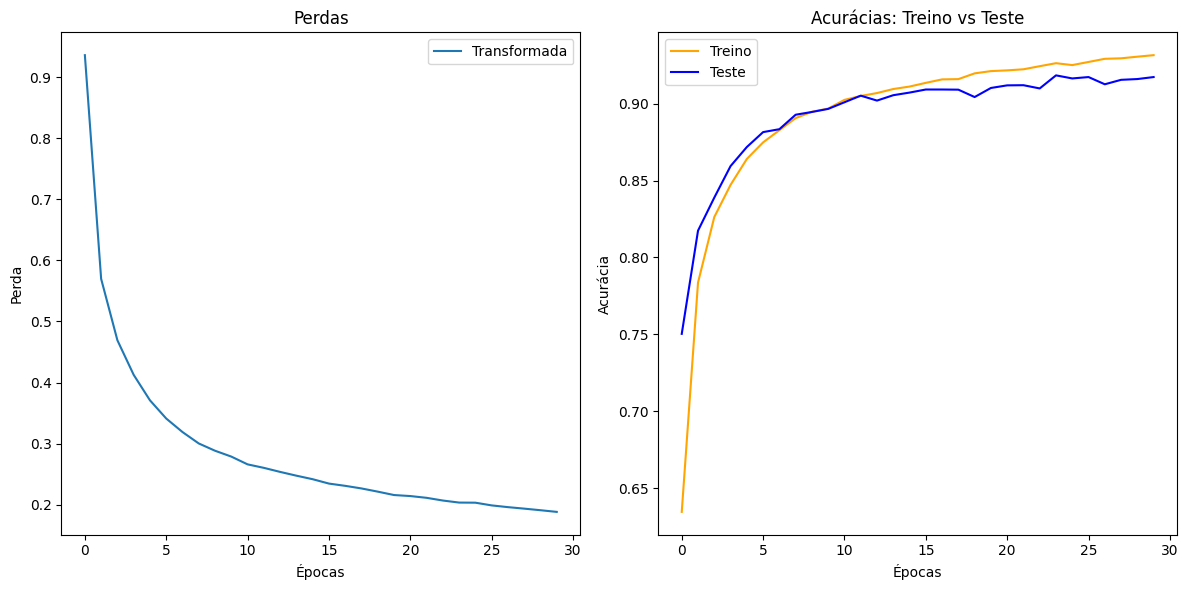

In [27]:
# Modelo 4 - Dataset C
modelo_4_c = CNN_Model_4(56, 10).to('cuda')
otimizador_4_c = torch.optim.Adam(modelo_4_c.parameters(), lr=0.001)
perda_4_c = nn.CrossEntropyLoss()

print('>>> Modelo 4 - Dataset C')
lista_perdas_4_C, acuracias_teste_4_C, acuracias_treino_4_C = treino(modelo_4_c, otimizador_4_c, perda_4_c, treino_loader_C, teste_loader_C, num_epocas=30)
plot_side_by_side(lista_perdas_4_C, acuracias_treino_4_C, acuracias_teste_4_C)